# Import Libraries

In [91]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import glob
import os
import sys


# Include src directory in path to import custom modules
if os.path.join("..", "src") not in sys.path:
    sys.path.append(os.path.join("..", "src"))

[autoreload of torch.overrides failed: Traceback (most recent call last):
  File "c:\Users\james\miniconda3\envs\pred-knee-replacement-oai\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\james\miniconda3\envs\pred-knee-replacement-oai\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\james\miniconda3\envs\pred-knee-replacement-oai\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "c:\Users\james\miniconda3\envs\pred-knee-replacement-oai\Lib\site-packages\torch\overrides.py", line 1661, in <module>
    has_torch_function = _add_docstr(
                    

: 

In [ ]:
sys.path

['c:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\notebooks',
 'c:\\Users\\james\\miniconda3\\envs\\pred-knee-replacement-oai\\python312.zip',
 'c:\\Users\\james\\miniconda3\\envs\\pred-knee-replacement-oai\\DLLs',
 'c:\\Users\\james\\miniconda3\\envs\\pred-knee-replacement-oai\\Lib',
 'c:\\Users\\james\\miniconda3\\envs\\pred-knee-replacement-oai',
 '',
 'c:\\Users\\james\\miniconda3\\envs\\pred-knee-replacement-oai\\Lib\\site-packages',
 'c:\\Users\\james\\miniconda3\\envs\\pred-knee-replacement-oai\\Lib\\site-packages\\win32',
 'c:\\Users\\james\\miniconda3\\envs\\pred-knee-replacement-oai\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\james\\miniconda3\\envs\\pred-knee-replacement-oai\\Lib\\site-packages\\Pythonwin',
 '..\\src',
 '..\\..\\src']

In [ ]:
os.getcwd()

'c:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\notebooks'

In [ ]:
# os.chdir("/content/drive/MyDrive/Projects/PhD/pred-knee-replacement-oai/src/")

In [ ]:
# Track reloads of custom modules - https://stackoverflow.com/questions/64158622/jupyter-does-not-see-changes-in-the-imported-module
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import importlib

from models.model_unet import UNet3D, UNet3DMulticlass
import models.evaluation
importlib.reload(models.evaluation) # reload step 1
from models.evaluation import dice_coefficient_batch, dice_coefficient, dice_coefficient_multi_batch_all

import data.datasets
importlib.reload(data.datasets)
from data.datasets import KneeSegDataset3D, KneeSegDataset3DMulticlass

import utils.utils
importlib.reload(utils.utils)
from utils.utils import crop_im, crop_mask


In [ ]:
os.getcwd()

'c:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\notebooks'

In [18]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

Current device: cpu


# Set Data Directories

In [21]:
# Define data directory - Local
DATA_DIRECTORY = 'C:\\Users\\james\\OneDrive - University of Leeds\\1. Projects\\1.1 PhD\\1.1.1 Project\\Data\\OAI Subset\\'
DATA_TEST_DIRECTORY = 'C:\\Users\\james\\OneDrive - University of Leeds\\1. Projects\\1.1 PhD\\1.1.1 Project\\Data\\OAI Subset\\test'
DATA_PROCESSED_DIRECTORY = os.path.join('..', 'data', 'processed')

RESULTS_PATH = os.path.join('..', 'results')
MODEL_WEIGHTS_DIR = os.path.join("..","models","checkpoints")
# MODEL_WEIGHTS_PATH = '..\\models\\checkpoints\\high_lr_40_epoch_best_E.pth'

# DATA_DIRECTORY = "/content/drive/MyDrive/Career/PhD/Project/Data"
# DATA_TEST_DIRECTORY = "/content/drive/MyDrive/Career/PhD/Project/Data/test"
# DATA_PROCESSED_DIRECTORY = "/content/drive/MyDrive/Projects/PhD/pred-knee-replacement-oai/data/processed"


In [22]:
# Define test file paths
test_paths = [os.path.basename(x).split(".")[0] for x in glob.glob(os.path.join(DATA_TEST_DIRECTORY, "*"))]
print(f"Number of test images: {len(test_paths)}")
print(f"Test paths first example: {test_paths[0:3]}")

Number of test images: 28
Test paths first example: ['test_001_V00', 'test_001_V01', 'test_002_V00']


# Binary Segmentation - Meniscus Only

## Create binary dataset and dataloader

In [ ]:
# Create test dataset
test_dataset = KneeSegDataset3D(test_paths, DATA_DIRECTORY, split='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
len(test_dataset)

28

In [ ]:
# Example image and segmentation mask
im, gt_mask = next(iter(test_loader))
print(f"Image shape after cropping: {im.shape}")
print(f"Ground truth mask shape after cropping: {gt_mask.shape}")

Image shape after cropping: torch.Size([1, 1, 200, 256, 160])
Ground truth mask shape after cropping: torch.Size([1, 1, 200, 256, 160])


In [ ]:
# Create model and load weights
model = UNet3D(1,1,16)
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device))

C:\Users\james\AppData\Local\Temp\ipykernel_120280\4251208348.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_lo

<All keys matched successfully>

In [ ]:
# Set model to evaluation mode
model.eval();

In [ ]:
im = im.to(device)
model.to(device)
pred_mask = model(im)

In [ ]:
dice_coefficient_batch(pred_mask,gt_mask).item()

Dice single pred shape: torch.Size([1, 1, 200, 256, 160])
Dice single mask shape: torch.Size([1, 1, 200, 256, 160])
intersection = 47962.734375
size = 1242300.875


0.07721596956253052

In [ ]:
pred_mask.shape

torch.Size([1, 1, 200, 256, 160])

In [ ]:
pred_slice_np = pred_mask[0,0,:,:,100].detach().cpu().numpy()
gt_slice_np = gt_mask[0,0,:,:,100].detach().cpu().numpy()

In [ ]:
pred_slice = pred_mask[0,0,:,:,100]
gt_slice = gt_mask[0,0,:,:,100]

In [ ]:
dice_coefficient(pred_slice,gt_slice,debug=True)

intersection = 410.527099609375
size = 7998.875


0.10264620929956436

(200, 256)


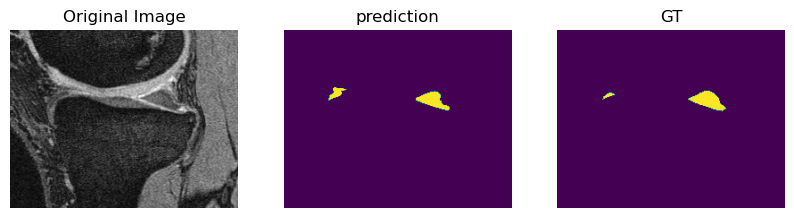

In [ ]:
import matplotlib.pyplot as plt

slice_num = 100

pred_mask_rem_channel = pred_mask[0][0].detach().cpu().numpy()
pred_binary_mask = (pred_mask_rem_channel>0.5).astype(int)
image = im[0][0].detach().cpu().numpy()
gt_mask_channel_rem = gt_mask[0][0]

pred_binary_slice = pred_binary_mask[...,slice_num]
image = image[...,slice_num]
gt_slice = gt_mask_channel_rem[...,slice_num]

print(pred_binary_slice.shape)

# Display the original image and the overlayed image using plt.imshow
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(pred_binary_slice)
ax[1].set_title('prediction')
ax[1].axis('off')

ax[2].imshow(gt_slice)
ax[2].set_title('GT')
ax[2].axis('off')

plt.show()

In [ ]:
dice_coefficient(torch.Tensor(pred_binary_slice), gt_slice)

0.8148148059844971

In [ ]:
pred_binary_slice.shape

(200, 256)

In [ ]:
gt_slice.shape

(200, 256)

In [ ]:
image.shape

(200, 256)

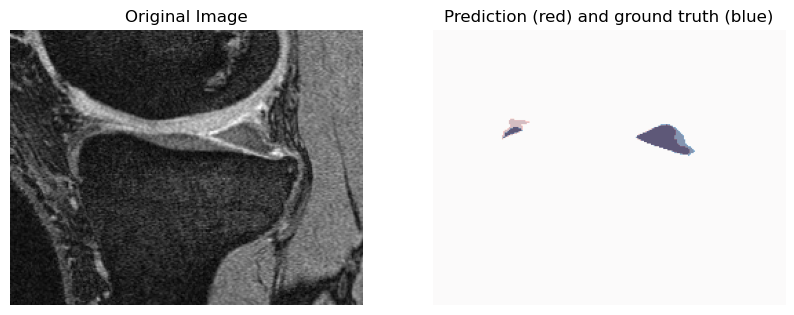

In [ ]:
# Display the original image and the overlayed image using plt.imshow
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(pred_binary_slice, cmap="Reds", alpha=0.5)
ax[1].set_title('Prediction (red) and ground truth (blue)')
ax[1].axis('off')

ax[1].imshow(gt_slice, cmap="Blues", alpha=0.5)
# ax[2].set_title('GT')
ax[1].axis('off')

plt.show()

# Multi-Class Segmentation

In [23]:
# create dataset/loader
# Create test dataset
test_multi_dataset = KneeSegDataset3DMulticlass(test_paths, DATA_DIRECTORY, num_classes=5, split='test')
test_multi_loader = DataLoader(test_multi_dataset, batch_size=1, shuffle=False)
len(test_multi_dataset)


28

In [24]:
# create model
model = UNet3DMulticlass(1, 5, 16)

# load model weights
weight_filename = "2024-09-03-01_17_27703401_high_lr_40_epoch_final.pth"
weights_path = os.path.join(MODEL_WEIGHTS_DIR, weight_filename)
multi_model_weights = torch.load(weights_path, map_location=torch.device('cpu'), weights_only=True)

# load weights into model
model.load_state_dict(multi_model_weights)

# set model to eval mode
model.eval

# load model to device
model.to(device)


UNet3DMulticlass(
  (enc1): EncBlock(
    (conv1): ConvBlock(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (enc2): EncBlock(
    (conv1): ConvBlock(
      (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [25]:
a = torch.tensor(np.ones(shape=(1,5,3,3,3)))
b = torch.tensor(np.random(shape=(1,5,3,3,3)))
dice_coefficient(a, b)


TypeError: 'module' object is not callable

In [ ]:
dice_scores = []

# loop through testloader (use tqdm)
for idx, (im, mask) in enumerate(test_multi_loader):

    # 	load im to device
    im.to(device)
    print(f"Image shape: {im.shape}")

    mask = mask.squeeze(axis=1)
    mask.to(device)
    print(f"Mask shape: {mask.shape}\n")

    # make prediction using model
    pred = model(im)
    print(f"Prediction shape: {pred.shape}\n")

    # convert model outputs from logits to probability
    pred_prob = nn.functional.softmax(pred, dim=1)

    pred_binary_mask = (pred>0.5).astype(int)

    # calculate dice coefficient
    dice = dice_coefficient(mask.squeeze(0).squeeze(0), pred_mask)
    dice_scores.append(dice)

    print(f"Im {idx+1} ({test_paths[idx]}): Dice = {dice}")

    # save predicted mask
    np.save(os.path.join(RESULTS_PATH, test_paths[idx]), pred_mask)

    # store dice score

Image shape: torch.Size([1, 1, 256, 264, 160])
Mask shape: torch.Size([1, 5, 256, 264, 160])

Prediction shape: torch.Size([1, 5, 256, 264, 160])

Image shape: torch.Size([1, 1, 256, 264, 160])
Mask shape: torch.Size([1, 5, 256, 264, 160])



: 

In [26]:
import h5py
split = "test"
# data_dir = DATA_DIRECTORY
# split_dir = os.path.join(DATA_DIRECTORY, split)
# print(split_dir)
# test__paths = os.listdir(split_dir)

# Choose first test image
test_path = test_paths[0]

# Test data is arranged differently, and as mask is numpy as opposed to h5py
# Load image and segmentation mask from test data (numpy arrays)
test_im_path = os.path.join(DATA_DIRECTORY, split, test_path + '.im')
test_seg_path = os.path.join(DATA_DIRECTORY, "test_gt", test_path + '.npy')

# Open the image file
with h5py.File(test_im_path,'r') as hf:
    test_image = np.array(hf['data'])

    # crop image/mask
    test_image = crop_im(test_image, dim1_lower=56, dim1_upper=312, dim2_lower=58, dim2_upper=322)

    print(f"Test image shape: {test_image.shape}")


# Load the mask
test_mask = np.load(test_seg_path)
test_mask = crop_im(test_mask, dim1_lower=56, dim1_upper=312, dim2_lower=58, dim2_upper=322)

print(f"Test mask shape: {test_mask.shape}")


# Load predicted mask
pred_mask = np.load(os.path.join(DATA_PROCESSED_DIRECTORY, test_path + ".npy"))
print(f"Predicted mask shape: {pred_mask.shape}")


Test image shape: (256, 264, 160)
Test mask shape: (256, 264, 160, 4)
Predicted mask shape: (1, 5, 256, 264, 160)


In [80]:
a = iter(test_multi_loader)

In [81]:
test_im_loader, test_mask_loader = next(a) # don't run again without reinitialising iter

In [82]:
test_multi_dataset.file_paths[0]

'test_001_V00'

In [83]:
print(f"Test image from loader shape: {test_im_loader.shape}")
print(f"Test mask from loader shape: {test_mask_loader.shape}")

Test image from loader shape: torch.Size([1, 1, 256, 264, 160])
Test mask from loader shape: torch.Size([1, 1, 5, 256, 264, 160])


In [84]:
test_mask_loader = test_mask_loader.squeeze(dim=1)
print(f"Test mask from loader shape: {test_mask_loader.shape}")

Test mask from loader shape: torch.Size([1, 5, 256, 264, 160])


In [85]:
test_pred = np.load(os.path.join(DATA_PROCESSED_DIRECTORY, test_path + '.npy'))
test_pred.shape

(1, 5, 256, 264, 160)

In [90]:
test_pred[0,1,:,:,30]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [87]:
dice_coefficient_multi_batch_all(
    torch.tensor(test_pred).float(),
    torch.tensor(test_mask_loader).float(),
    num_labels=5
)

<ipython-input-87-3f2b1d02037d>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(test_mask_loader).float(),


Multiclass Dice loss pred_mask_batch shape = torch.Size([1, 5, 256, 264, 160])
Multiclass Dice loss gt_mask_batch shape = torch.Size([1, 5, 256, 264, 160])


tensor([0.5667, 0.0740, 0.0251, 0.0094, 0.0322])

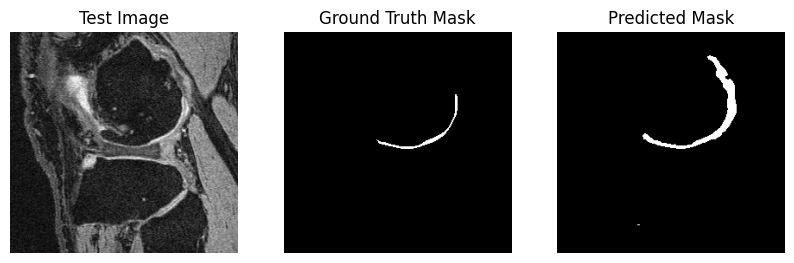

In [78]:
# Plot loader version

import matplotlib.pyplot as plt

slice_num = 30
class_num = 1

# create 3 matplotlib subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Plot the test image, ground truth mask and predicted mask in each subplot
ax[0].imshow(test_im_loader[0,0,:,:,slice_num], cmap='gray')
ax[0].set_title('Test Image')
ax[0].axis('off')

ax[1].imshow(test_mask_loader[0,class_num, :,:,slice_num], cmap='gray')
ax[1].set_title('Ground Truth Mask')
ax[1].axis('off')

ax[2].imshow(pred_mask[0,class_num, :, :, slice_num], cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

# Show the plot
plt.show()

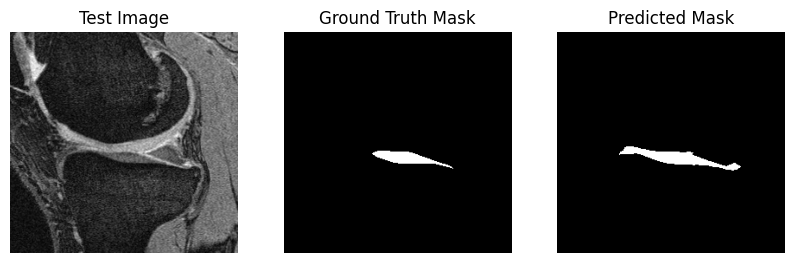

In [ ]:
# Plot non-loader version

slice_num = 100
class_num = 1

# create 3 matplotlib subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Plot the test image, ground truth mask and predicted mask in each subplot
ax[0].imshow(test_image[:,:,slice_num], cmap='gray')
ax[0].set_title('Test Image')
ax[0].axis('off')

ax[1].imshow(test_mask[:,:,slice_num, class_num], cmap='gray')
ax[1].set_title('Ground Truth Mask')
ax[1].axis('off')

ax[2].imshow(pred_mask[0,class_num + 1, :, :, slice_num], cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

# Show the plot
plt.show()